<a href="https://colab.research.google.com/github/chathumal93/ADB-EARR-T4/blob/main/Building_Stability_Monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup
Run below code to intall all the additional packages needed for this notebook.

In [1]:
# Installing Necessary packages
%%capture
!pip install rtree
!pip install git+git://github.com/geopandas/geopandas.git
!pip install leafmap
!pip install keplergl
!pip install mapclassify
!pip install contextily

In [2]:
# Importing required modules
import os
import zipfile
import numpy as np
import pandas as pd
from shapely.geometry import Point
import geopandas
from geopandas import GeoDataFrame
import leafmap
from scipy.spatial import KDTree
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

Run below code to ingest all the required data for this practial task into google colab system for further processing.

In [3]:
# Cloning the git repository to access the data 
!git clone https://github.com/chathumal93/ADB-EARR-T4.git

Cloning into 'ADB-EARR-T4'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [4]:
# Extracting the data.zip file to ADB-EARR-T4 folder
with zipfile.ZipFile('/content/ADB-EARR-T4/Data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ADB-EARR-T4')

# Exploring Geohazard Expolitation Platform Results


Run below code to access the **GEP PSI** data in CSV format.

In [5]:
# Accessing the SNAPPING PSI products
# Data in Ascending direction
PSI_Asc = '/content/ADB-EARR-T4/1_GEP_SNAPPING_PSI_Data/GEP_SNAPPING_PSI_20181016_20210906_ASC.csv'

# Data in Descending direction
PSI_Des = '/content/ADB-EARR-T4/1_GEP_SNAPPING_PSI_Data/GEP_SNAPPING_PSI_20181110_20210814_DES.csv'

Run below code to read the **Building dataset** and the **Grided AOI** in shape file format as geodataframes.

In [6]:
# Reading the BIG Building file as a geodataframe.(A clipped Section from the BIG 2019 bulding data set included in the project geoportal)
Palu_Bld = geopandas.read_file('/content/ADB-EARR-T4/3_BLD_Data/building_utm_extended_v7_clip.shp')

# Reading Grided AOi as a geodataframe
Palu_Grid = geopandas.read_file('/content/ADB-EARR-T4/3_BLD_Data/building_utm_extended_v7_clip_grid.shp')

Run below code to define the function, which converts the GEP PSI product into a dataframe

In [7]:
# function for CSV to Dataframe conversion (PSI-result)
def csv2df(csv_file_path):
  """
  This function converts the GEP PSI products in to a dataframe
  """
  # Read PSI data in csv format into a dataframe
  data = pd.read_csv(csv_file_path,sep=';',skiprows=16)
  
  # Image list (dates) in the csv
  slv_img_list = list(data.columns)[6:]
                              
  # Renaming the columns
  column_names_01 = ['ID','Lat','Lon','V_LOS','V_STD','INC_ANG']

  # Image name list with date
  column_names_02 = []

  # Re-arranging the column names (This is based on the EARR project geo-portal visualization requirement)
  # Getting the date tag of images
  for datetime_tag in range(len(slv_img_list)):
      column_names_02.append('DL'+ str(slv_img_list[datetime_tag]))

  # Final Column names for the dataframe    
  column_all = column_names_01 + column_names_02

  # Final Dataframe creation with the arranged data and column names
  data.columns = column_all

  return data

Run below code to convert PSI Ascending and Descending product to dataframes (**df_Asc** and **df_Des**).

In [8]:
# Converting PSI ASc CSV file as df_Asc dataframe
df_Asc = csv2df('/content/ADB-EARR-T4/1_GEP_SNAPPING_PSI_Data/GEP_SNAPPING_PSI_20181016_20210906_ASC.csv')

# Converting PSI Des CSV file as df_Des dataframe
df_Des = csv2df('/content/ADB-EARR-T4/1_GEP_SNAPPING_PSI_Data/GEP_SNAPPING_PSI_20181110_20210814_DES.csv')

# Data Insights

Beofre plotting the PSI data geometrically in both directions, distribution of **Line of Sight (LoS) Velocity** in each direction, will be displayed from the following code.

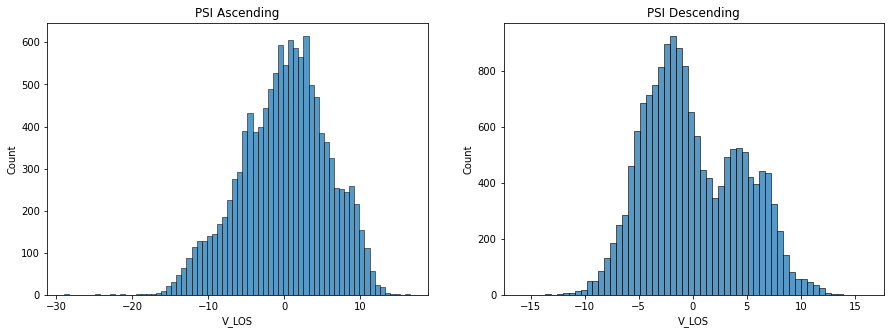

In [9]:
# Ploting histograms of PSI LOS data in Ascending and Descending directions
fig, axes = plt.subplots(1,2,figsize=(15,5))
# Ascending
sns.histplot(ax=axes[0], data=df_Asc["V_LOS"])
axes[0].set_title('PSI Ascending')
# Descending
sns.histplot(ax=axes[1], data=df_Des["V_LOS"])
axes[1].set_title('PSI Descending')
plt.show()

In [10]:
# PSI LOS Velocity Statistics considering the whole coverage (Asc)
df_Asc["V_LOS"].describe()

count    12289.000000
mean        -0.000030
std          5.708653
min        -28.930000
25%         -3.880000
50%          0.360000
75%          3.940000
max         16.580000
Name: V_LOS, dtype: float64

In [11]:
# PSI LOS Velocity Statistics considering the whole coverage (Des)
df_Des["V_LOS"].describe()

count    16192.000000
mean        -0.000045
std          4.498136
min        -15.900000
25%         -3.390000
50%         -0.800000
75%          3.670000
max         16.110000
Name: V_LOS, dtype: float64

# Data Visualization

In this section, all the data will be converted into a format (**geodataframe**) which can be mapped in a static or interactive environment.


Run below code to define the function, which converts the PSI dataframe into a geodataframe in **EPSG:32750** projected coordinate system

In [12]:
def df2gdf_utm(df):
  """
  This function converts the data frame  in to a geodataframe based on WGS 84 / UTM zone 50S
  df: dataframe of PSI data (Asc/Des)
  """
  # Accessing the Lat and Long from dataframe for geometry conversion
  geometry = [Point(xy) for xy in zip(df.Lon, df.Lat)]
  gdf = GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)

  # Coverting gdf from EPSG:4326 to EPSG:32750 – WGS 84 / UTM zone 50S
  # For the stabilty analysis the points needs to be in meter(m) format
  gdf_utm = gdf.to_crs("EPSG:32750")

  return gdf_utm

Run below code to use the above funtion and convert Ascending and Desceding PSI dataframes into geodataframes.

In [13]:
# Converting df_Asc dataframe into gdf_Asc geodataframe
gdf_Asc = df2gdf_utm(df_Asc)

# Converting df_Des dataframe into gdf_Des geodataframe
gdf_Des = df2gdf_utm(df_Des)

Run below code to plot **gdf_Asc** and **gdf_Des** geodataframes into static maps.

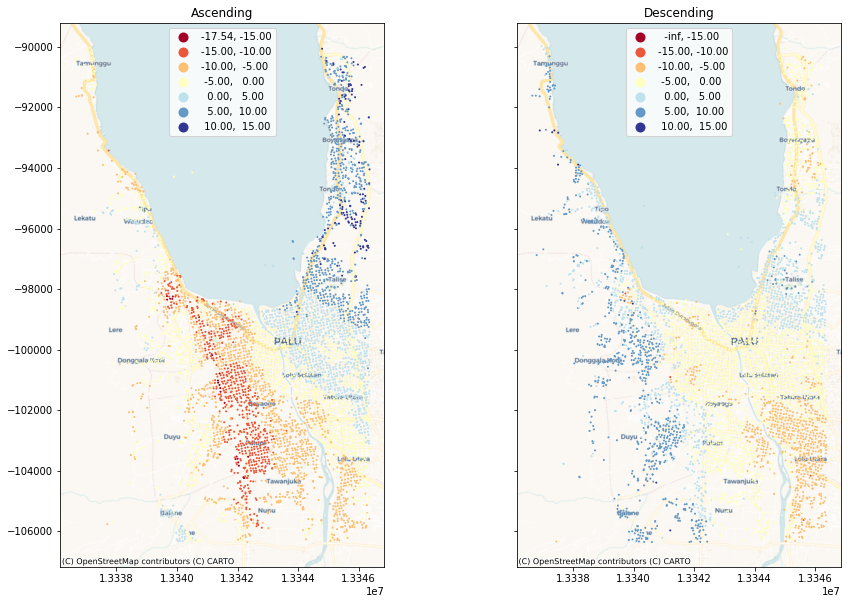

In [14]:
# Reading PSI values within Palu_Grid
gdf_2_plot_A = geopandas.overlay(gdf_Asc, Palu_Grid, how='intersection')
#gdf_2_plot_A = gdf_2_plot_A.loc[(gdf_2_plot_A["V_LOS"]>=-30) | (gdf_2_plot_A['V_LOS']<=30)]

gdf_2_plot_D = geopandas.overlay(gdf_Des, Palu_Grid, how='intersection')
#gdf_2_plot_D = gdf_2_plot_D.loc[(gdf_2_plot_D["V_LOS"]>=-30) | (gdf_2_plot_D['V_LOS']<=30)]

# Conversion of projection to match with basemap
gdf_2_plot_A = gdf_2_plot_A.to_crs(epsg=3857)
gdf_2_plot_D = gdf_2_plot_D.to_crs(epsg=3857)

# Plotting the PSI products 
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True,figsize=(15,10))
# Map for Ascending product
map01 = gdf_2_plot_A.plot(ax=ax1,column="V_LOS",figsize=(10,10),cmap='RdYlBu',legend=True,scheme='User_Defined',k=5,markersize=1,classification_kwds=dict(bins=[-15,-10,-5,0,5,10,15])) 
ax1.title.set_text('Ascending')
cx.add_basemap(map01, source=cx.providers.CartoDB.Voyager)

# Map for Descending product
map02 =gdf_2_plot_D.plot(ax=ax2,column="V_LOS",figsize=(10,10),cmap='RdYlBu',legend=True,scheme='User_Defined',k=5,markersize=1,classification_kwds=dict(bins=[-15,-10,-5,0,5,10,15])) 
ax2.title.set_text('Descending')
cx.add_basemap(map02, source=cx.providers.CartoDB.Voyager)

Run the code below to visualize the **Grided AOI** in a interactive web map. Based on this grid system, building motion analyze can be done in the next section.

In [ ]:
from leafmap import basemaps
import leafmap.kepler as leafmap

# Initiating a map object
map01 = leafmap.Map(center=(-0.88, 119.86), zoom=11, height=500)
# Adding grid geodataframe to map object
map01.add_gdf(Palu_Grid, layer_name="Grid")
# Displaying map
map01 

User can select a plot from the **Grided AOI/Palu_Grid**. Based on the attributes(**'PageName'**) of the Grided AOI, user will be able to  get all the buildings belong to that selected plot. In this notebook plot E3 is selected and processed further.

In [16]:
# Selecting a plot from the grid for the building motion analyze and select all the building in the selected slot
E3 = Palu_Grid.loc[Palu_Grid['PageName'] == "E3"]

# Building selection whithin in the plot
Palu_Bld_E3 = geopandas.overlay(Palu_Bld, E3, how='intersection')

Run the code below to visualize the **Selected Buildings** in the same interactive web map format.

In [ ]:
# Adding the selected building within the the defined plot
# Initiating a map object
map02 = leafmap.Map(center=(-0.88, 119.86), zoom=11, height=500)
# Adding grid geodataframe to map object
map02.add_gdf(Palu_Bld_E3, layer_name="Buildings_subset")
# Displaying map
map02

# LOS Velocity interpolation

In this section Nearest Neighbour Interpolation approach will be use to assign LOS velocity vlaues of persistence scatterers to the building dataset.

Integrating PSI Line of Sight Velocity values to Buildings
  
In this section priority will be given to the PSI data in the Ascending direction.

In [18]:
# Reading the selected Geodataframe as PSI variable
PSI = gdf_Asc

In [19]:
# Assign displacement range 30 mm to -30 mm
PSI = PSI.loc[(PSI['V_LOS']>=-30) | (PSI['V_LOS']<=30)]

# Getting PSI UTM 50S co-ordinates
PSI_coordts = []
for row in PSI['geometry']:
    PSI_LON = float(str(row).split('POINT (')[1].split(')')[0].split(' ')[0])
    PSI_LAT = float(str(row).split('POINT (')[1].split(')')[0].split(' ')[1])
    PSI_coordts.append([PSI_LON,PSI_LAT])
    
PSI_coordts = np.array(PSI_coordts)

Run below codes to estimate centroid for each building in **Palu_Bld** layer.



In [20]:
# Building centroid estimation
# Reading the Buildings as a geodataframe from the selected grid plot
# If needed the whole buidling layer, Palu_Bld.copy() can be used
BLD_CEN = Palu_Bld_E3.copy()

In [21]:
# Calculate the centroid
BLD_CEN.geometry = BLD_CEN['geometry'].centroid
# Define the coordinate system for the new geodataframe
BLD_CEN.crs = Palu_Bld.crs

In [22]:
# Getting Building centroid co-ordinates to a numpy array : B_coordts --> [[Lon,Lat]]
B_coordts = []
for row in BLD_CEN['geometry']:
    B_LON = float(str(row).split('POINT (')[1].split(')')[0].split(' ')[0])
    B_LAT = float(str(row).split('POINT (')[1].split(')')[0].split(' ')[1])
    B_coordts.append([B_LON,B_LAT])  
B_coordts = np.array(B_coordts)

Run below code to define the function, which execute the **Nearest Neighbour** interpolation of **PSI data** based on the location of **building centroids**.

In [23]:
def NN_buf_KDTree(New_CO,Old_V,Old_CO,buffer_m):

  """
  This function assigns the nearest neighbour value for a new point based on the difined distance from a old point which has the location and value components.

  New_CO : Coordinates of new points (to assign the interpolated data)
  Old_CO : Coordinates of old points
  Old_V : Values of old points to be interpolated
  buffer_m : Buffer distance in meters
  """  
  Tree = KDTree(Old_CO,)

  NN_Buff_Values = []
  for item in range(len(New_CO)):

    dd, ii = Tree.query(New_CO[item], k=1)

    # [distance , index]
    dd_ii = np.c_[dd,ii]

    if (dd_ii[0,0] <= buffer_m) & (dd_ii[0,0] >= 0):
      intpl_value = Old_V[int(dd_ii[0][1])][0]
      NN_Buff_Values.append(intpl_value)

    else :
      intpl_value = -9999
      NN_Buff_Values.append(intpl_value)

  return NN_Buff_Values

In [24]:
# Getting PSI ground motion values to a numpy array : PSI_values --> [V1,...,Vn]
PSI_values = np.array(PSI.V_LOS)

# Arranging arrays according to the NN_buf_KDTree function  : xyz --> [[Lon,Lat,Velocity]]
xyz = np.c_[PSI_coordts,PSI_values]

# PSI_vel: [[V1],[V2]....,[Vn]]
PSI_vel = xyz[:,2:]

In [25]:
# Getting new (interpolated) values to building centroids
interpolated_vals = NN_buf_KDTree(B_coordts,PSI_vel,PSI_coordts,100)
interpolated_vals = np.array(interpolated_vals)

# Building Stability Classification

Based on the interpolated LOS Velcity values of building centriods will be used for the stability or motion classification.

In [26]:
# Based on the standard deviation of V_LOS values, levels of motion can be defined.
# STD value for Asc PSI product
std_val = np.std(df_Asc["V_LOS"])

#Medium motion : 2*std to 1*std
#Low motion : 1*std to -1*std
#High motion : >2*std and <-2*std

positive_l =  1*std_val
positive_h =  2*std_val
negative_l = -1*std_val
negative_h = -2*std_val
no_Data = -9999.0

Run below code to classify the interpolated motion values in to three main categories **Low, Medium** and **High**. Building centroids without any interpolated values, will be classified as no data.

In [27]:
# Intiating a null array for interpolated values
b_i = np.array([])

# Classification base on the PSI value distribution
for i in interpolated_vals:
  if (i == no_Data):
    b_i = np.append(b_i,'nan')           
  elif ((i >= negative_l) and (i <= positive_l)): 
    b_i = np.append(b_i,'Low')     
  elif ((i < negative_l) and (i >= negative_h)):
    b_i = np.append(b_i,'Medium')             
  elif ((i > positive_l) and (i <= positive_h)):        
    b_i = np.append(b_i,'Medium')               
  elif ((i < negative_h) or (i > positive_h)):            
    b_i = np.append(b_i,'High')             
  else:
    b_i = np.append(b_i,no_Data)

In [28]:
# Decription of the data
values, counts = np.unique(b_i, return_counts=True)
print('values:',values, "count: ",counts) 

values: ['High' 'Low' 'Medium' 'nan'] count:  [ 806 1663 4866   14]


In [29]:
# Attaching interpolated values to building section
#Creating a copy of a selected building plot
Palu_Bld_E3_motion = Palu_Bld_E3.copy()

Palu_Bld_E3_motion['Vel_mm']  = pd.Series(interpolated_vals)
Palu_Bld_E3_motion['motion'] = pd.Series(b_i)

In [30]:
# Geodataframe information
Palu_Bld_E3_motion.head()

,OBJECTID_1,PageName,PageNumber,geometry,Vel_mm,motion
0,54759,E3,14,"POLYGON ((816617.802 9900388.114, 816614.341 9...",-10.70,Medium
1,54768,E3,14,"POLYGON ((817780.791 9900405.979, 817774.185 9...",-5.71,Medium
2,54771,E3,14,"POLYGON ((817634.046 9900401.274, 817623.552 9...",-8.24,Medium
3,54773,E3,14,"POLYGON ((817929.268 9900404.305, 817911.483 9...",-5.37,Low
4,54774,E3,14,"POLYGON ((817953.619 9900406.656, 817938.445 9...",-5.37,Low


# Final Product
Run the below code to visualize the processed building stability layer in a web map.

In [ ]:
# Visualization of the final product
# Initiating a map object
map03 = leafmap.Map(center=(-0.88, 119.86), zoom=11, height=500)
# Adding grid geodataframe to map object
map03.add_gdf(Palu_Bld_E3_motion, layer_name="Building_motion")
# Displaying map
map03

Run below code to create a result folder to store processed data

In [32]:
# Creating a result folder to store the results for visualization
if not os.path.exists('/content/ADB-EARR-T4/4_Results'):
  os.makedirs('/content/ADB-EARR-T4/4_Results')

Run below code export selected GEP PSI product in a shape file format

In [33]:
# Below code can be used to covert the geodataframe to a shape file in Google Colab drive and the file can be downloaded to local computer.
# Export gdf as a shp
gdf_Asc.to_file('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_20181016_20210906_ASC.shp')
# create a ZipFile object
zipObj = zipfile.ZipFile('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_20181016_20210906_ASC.zip', 'w')

# Add multiple files to the zip
zipObj.write('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_20181016_20210906_ASC.dbf',arcname='GEP_SNAPPING_PSI_20181016_20210906_ASC.dbf')
zipObj.write('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_20181016_20210906_ASC.prj',arcname='GEP_SNAPPING_PSI_20181016_20210906_ASC.prj')
zipObj.write('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_20181016_20210906_ASC.shp',arcname='GEP_SNAPPING_PSI_20181016_20210906_ASC.shp')
zipObj.write('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_20181016_20210906_ASC.shx',arcname='GEP_SNAPPING_PSI_20181016_20210906_ASC.shx')

# close the Zip File
zipObj.close()

# Downloading the GEP SNAPPING PSI product to local machine
#files.download('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_20181016_20210906_ASC_SHP.zip')

Run below code export final GEP PSI Building Stability product in shape file format

In [34]:
# Below code can be used to covert the geodataframe (building motion) to a shape file in Google Colab drive and the file can be downloaded to local computer.
# Export gdf as a shp
Palu_Bld_E3_motion.to_file('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_BLD_STB.shp')
# create a ZipFile object
zipObj = zipfile.ZipFile('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_BLD_STB.zip', 'w')

# Add multiple files to the zip
zipObj.write('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_BLD_STB.dbf',arcname='GEP_SNAPPING_PSI_BLD_STB.dbf')
zipObj.write('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_BLD_STB.prj',arcname='GEP_SNAPPING_PSI_BLD_STB.prj')
zipObj.write('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_BLD_STB.shp',arcname='GEP_SNAPPING_PSI_BLD_STB.shp')
zipObj.write('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_BLD_STB.shx',arcname='GEP_SNAPPING_PSI_BLD_STB.shx')

# close the Zip File
zipObj.close()

# Downloading the GEP SNAPPING PSI Building motion product to local machine
#files.download('/content/ADB-EARR-T4/4_Results/GEP_SNAPPING_PSI_BLD_STB.zip')